# <center> Anomaly Detection in Images

In this notebook, we will delve into the exciting realm of anomaly detection in images. Our focus will be on two powerful methods: DRAEM and CFA. We'll explore how these approaches tackle the challenge of detecting anomalies, leveraging the MVTEC dataset for evaluation. DRAEM excels in generating abnormal samples to improve detection performance, while CFA maximizes robustness by utilizing pretrained networks for feature extraction.

## Outline    
* MVTEC Dataset
* Anomaly Generation based methods: Draem
    * Implementation using Anomalib
    * Results
* Pretrain network methods: CFA
    * Implementation using Anomalib
    * Results
* Gradio and Hugging Face
    

## Dataset: MVTec AD

The [MVTEC dataset](https://www.mvtec.com/company/research/datasets/mvtec-ad) is a widely used benchmark for evaluating anomaly detection methods, specifically in the context of industrial inspection. It consists of more than 5000 high-resolution images across 15 different object and texture categories. Each category includes a training set of defect-free images and a test set comprising images with various types of defects, as well as defect-free images for comparison. If the dataset is not already present in the root datasets directory, you can rely on the anomalib library to automatically install it.

Some of the classes/categories included in the MVTEC dataset are:

* Bottle
* Cable
* Capsule
* Carpet
* Grid
* Hazelnut
* Leather
* Metal-Nut
* Pill
* Screw
* Tile
* Toothbrush
* Transistor
* Wood
* Zipper

By importing the MVtec AD dataset using the specific datamodule provided by anomalib, we can easily access the images and associated labels for anomaly detection tasks in Jupyter Notebook.








![picture](https://drive.google.com/uc?export=view&id=1g2TC2Z83ciiivXbWz27oXJyUA94KySBI)

## Anomalib
[Anomalib](https://github.com/openvinotoolkit/anomalib): Anomalib is a deep learning library that aims to collect state-of-the-art anomaly detection algorithms for benchmarking on both public and private datasets. Anomalib provides several ready-to-use implementations of anomaly detection algorithms described in the recent literature, as well as a set of tools that facilitate the development and implementation of custom models. The library has a strong focus on image-based anomaly detection, where the goal of the algorithm is to identify anomalous images, or anomalous pixel regions within images in a dataset.

The library supports [`MVTec AD`](https://www.mvtec.com/company/research/datasets/mvtec-ad) (CC BY-NC-SA 4.0) for **benchmarking**.



## DRÆM- Model

In this part, we'll be covering [DRÆM–A discriminatively trained reconstruction embedding for surface anomaly detection](https://openaccess.thecvf.com/content/ICCV2021/papers/Zavrtanik_DRAEM_-_A_Discriminatively_Trained_Reconstruction_Embedding_for_Surface_Anomaly_ICCV_2021_paper.pdf). 

DRÆM learns a joint representation of an anomalous image and its anomaly-free reconstruction, while simultaneously learning a decision boundary between normal and anomalous examples.

* The reconstructive sub-network is trained to implicitly detect and reconstruct the anomalies with semantically plausible anomaly-free content, while keeping the non-anomalous regions of the input image unchanged.

* Simultaneously, the discriminative sub-network learns a joint reconstruction-anomaly embedding and produces ac- curate anomaly segmentation maps from the concatenated reconstructed and original appearance.

* Anomalous training examples are created by a conceptually simple process that simulates anomalies on anomaly-free images.

* This anomaly generation method provides an arbitrary amount of anomalous samples as well as pixel-perfect anomaly segmentation maps which can be used for training the proposed method without real anomalous samples.

* **reconstructive sub-network** is formulated as an encoder-decoder architecture that converts the local patterns of an input image into patterns closer to the distribution of normal samples.

$$
L_{r e c}\left(I, I_r\right)=\lambda L_{S S I M}\left(I, I_r\right)+l_2\left(I, I_r\right),
$$


<center>
<img src="https://drive.google.com/uc?export=view&id=1hTdOvGs-D_L6xc99DrSPJ3Vf74fStQuO" width="700" aligh="center">
</center>

* **Discriminative sub-network** The sub-network input $I_c$ is deﬁned as the channel-wise concatenation of the reconstructive subnetwork output $I_r$ and the input image $I$. Due to the normality-restoring property of the reconstructive subnetwork, the joint appearance of $I$ and $I_r$ differs signiﬁcantly in anomalous images, providing the information necessary for anomaly segmentation.

* the discriminative sub-network learns the appropriate distance measure automatically. The network outputs an anomaly score map $M_o$ of the same size as $I$. Focal Loss (Lseg) is applied on the discriminative sub-network output to increase robustness towards accurate segmentation of hard examples.

* Considering both the segmentation and the reconstructive objectives of the two sub-networks, the total loss used in training DRÆM is

$$
L\left(I, I_r, M_a, M\right)=L_{r e c}\left(I, I_r\right)+L_{s e g}\left(M_a, M\right)
$$

where $Ma$ and $M$ are the ground truth and the output anomaly segmentation masks, respectively.

## DRÆM- Simulated Anomaly Generation

* A noise image is generated by a Perlin noise generator to capture a variety of anomaly shapes (The below figure $P$) and binarized by a threshod sampled uniformly at random (The below figure, $M_a$) into an anomaly map $M_a$. The anomaly texture source image $A$ is sampled from an anomaly source image dataset which is unrelated to the input image distribution. Random augmentation sampling is then applied by a set of 3 random augmentation functions sampled from the set: {posterize, sharpness, solarize, equalize, brightness change, color change, auto-contrast}. The augmented texture image $A$ is masked with the anomaly map Ma and blended with $I$ to create anomalies that are just-out-of- distribution, and thus help tighten the decision boundary in the trained network. The augmented training image $I_a$ is therefore deﬁned as 

$$
I_a=\bar{M}_a \odot I+(1-\beta)\left(M_a \odot I\right)+\beta\left(M_a \odot A\right)
$$

where $\bar{M}_a$ is the inverse of $M_a, \odot$ is the element-wise multiplication operation and $\beta$ is the opacity parameter in blending. This parameter is sampled uniformly from an in-



<center>
<img src="https://drive.google.com/uc?export=view&id=1hWdIeJ1hgx7lVS0lfK1IdhA0rnKXGAxn" width="500" aligh="center">
</center>



## DRÆM- Simulated Anomlay Generation Samples

The below image shows some example of simulated anomalies


<center>
<img src="https://drive.google.com/uc?export=view&id=1h4xaMThjs_LZDm69zHEmWaprFIYG6NuH" width="600" aligh="center">
</center>



## DRÆM- Localization and Detection

The output of the discriminative sub-network is a pixel-level anomaly detection mask $M_o$, which can be interpreted in a straightforward way for the image-level anomaly score estimation, 


First, $M_o$ is smoothed by a mean filter convolution layer to aggregate the local anomaly response information. The final image-level anomaly score $\eta$ is computed by taking the maximum value of the smoothed anomaly score map:
$$
\eta=\max \left(M_o * f_{s_f \times s_f}\right),
$$
where $f_{s_f \times s_f}$ is a mean filter of size $s_f \times s_f$ and $*$ is the convolution operator. 


## DRAEM - Metrics

* AUROC : ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1

* I-AUROC: Image level AUROC
* P-AUROC: Pixel Level AUROC



## DRÆM- Result

* Results for the task of anomaly localization on the MVTec dataset (AUROC - Pixel Level).

<center>
<img src="https://drive.google.com/uc?export=view&id=1KTiPj5sq6rAeuCoFW_t7d8lXsfLqESAC" width="400" aligh="center">
</center>

* Results for the task of anomaly localization on the MVTec dataset (AUROC - Image Level).

<center>
<img src="https://drive.google.com/uc?export=view&id=1fC2HKKUTKzyRtTqS486nx-K4qkziyYYw" width="400" aligh="center">
</center>

1: GANomaly: Semi-supervised anomaly detection via adversarial training

4: Uninformed students:Student-teacher anomaly detection with discriminative latent embeddings

11: Padim:a patch distribution modeling framework for anomaly detection and localization

20: Modeling the distribution of normal data in pre-trained deep features for anomaly detection

26: Anomaly detection neural network with dual auto-encoders gan and its industrial inspection applications

31: Reconstruction by inpainting for visual anomaly detection





## DRÆM- Result

* Qualitative examples. The original image, the anomaly map overlay, the anomaly map and the ground truth map are shown.

<center>
<img src="https://drive.google.com/uc?export=view&id=1hmlyZByduj-bIW0uV9rH1RKhV88dUovF" width="800" aligh="center">
</center>




## Further reading

* [Fake It Until You Make It : Towards Accurate Near-Distribution Novelty Detection](https://openreview.net/forum?id=QWQM0ZwZdRS)

* [G2D: Generate to Detect](https://openaccess.thecvf.com/content/WACV2021/papers/Pourreza_G2D_Generate_to_Detect_Anomaly_WACV_2021_paper.pdf)

## Installing Anomalib

Installation can be done in two ways: 
* (i) install via PyPI.
* (ii) installing from sourc, both of which are shown below:

### I. Install via PyPI

In [1]:
# Option - I: Uncomment the next line if you want to install via pip.
#%pip install anomalib
#%pip install openvino
#%pip install openvino-dev
#%pip install openvino-telemetry
#%pip install openvino-colab
#%pip install gitpython
#%pip install onnx

### II. Install from Source
This option would initially download anomalib repository from github and manually install `anomalib` from source, which is shown below:

In [2]:
# Option - II: Uncomment the next three lines if you want to install from the source.
# !git clone https://github.com/openvinotoolkit/anomalib.git
# %cd anomalib
# %pip install .


 Now let's verify the working directory. This is to access the datasets and configs when the notebook is run from different platforms such as local or Google Colab or Vector Jupyter hub.

In [1]:
## Import libraries
from __future__ import annotations
import os
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
from typing import Any
from IPython.display import Image
from anomalib.data import InferenceDataset, TaskType
from git.repo import Repo
from anomalib.data.utils import InputNormalizationMethod, get_transforms
from anomalib.post_processing import (
    NormalizationMethod,
    ThresholdMethod,
    superimpose_anomaly_map,
)
from torch.utils.data import DataLoader


#set the path for main folder
current_directory = Path.cwd()
root_directory = current_directory / "anomalib"

#change directory to the project folder
os.chdir(root_directory)
print(root_directory)

/ssd003/home/mpourreza/Projects/AD_bootcamp/MVTec/anomalib


## Imports

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from pytorch_lightning import Trainer
from torchvision.transforms import ToPILImage

from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.data.utils import read_image
from anomalib.deploy import OpenVINOInferencer,TorchInferencer
from anomalib.models import get_model
from anomalib.pre_processing.transforms import Denormalize
from anomalib.utils.callbacks import LoadModelCallback, get_callbacks

To use wandb logger install it using `pip install wandb`


In [6]:
MODEL = "draem" # choosing the model 
CONFIG_PATH = root_directory / f"src/anomalib/models/{MODEL}/config.yaml" # detailed configs loaded from this file
print(CONFIG_PATH)

/ssd003/home/mpourreza/Projects/AD_bootcamp/MVTec/anomalib/src/anomalib/models/draem/config.yaml


In [7]:
# pass the config file to model, callbacks and datamodule
config = get_configurable_parameters(config_path=CONFIG_PATH)
print(config.dataset.category)
# config.dataset.category = "bottle" # Choosing the classes from MVTec classes

bottle


In [8]:
datamodule = get_datamodule(config)
datamodule.prepare_data()  # Downloads the dataset if it's not in the specified `root` directory
datamodule.setup()  # Create train/val/test/prediction sets.

i, data = next(enumerate(datamodule.val_dataloader()))
print(data.keys())

dict_keys(['image_path', 'label', 'image', 'mask_path', 'mask'])


Let's check the shapes of the input images and masks.

In [9]:
print(data["image"].shape, data["mask"].shape)

torch.Size([32, 3, 256, 256]) torch.Size([32, 256, 256])


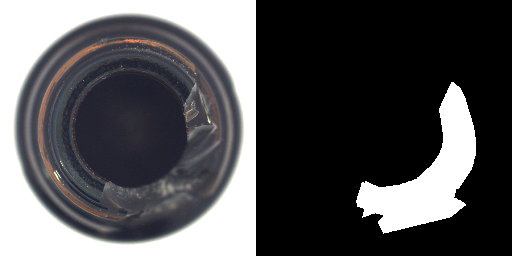

In [10]:
def show_image_and_mask(sample: dict[str, Any], index: int) -> Image:
    """
    Display an image and its corresponding mask side by side.

    Args:
        sample (dict[str, Any]): A dictionary containing the image and mask arrays.
        index (int): The index of the specific image and mask to display.

    Returns:
        Image: The concatenated image and mask as a PIL Image object.
    """
    img = ToPILImage()(Denormalize()(sample["image"][index].clone()))
    msk = ToPILImage()(sample["mask"][index]).convert("RGB")

    return Image.fromarray(np.hstack((np.array(img), np.array(msk))))


# Visualize an image with a mask
show_image_and_mask(data, index=0)

In [10]:
# Set the export-mode to Torch to create the Torch IR model.
config.optimization.export_mode = "torch"

# Get the model and callbacks / Download the wide_resnet50 from pytorh hub
model = get_model(config)
callbacks = get_callbacks(config)

## Training the model

In [11]:
# start training
trainer = Trainer(**config.trainer, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | AnomalyScoreThreshold    | 0     
1 | pixel_threshold       | AnomalyScoreThreshold    | 0     
2 | model                 | DraemModel               | 97.4 M
3 | loss             

Epoch 0:  91%|█████████ | 31/34 [01:05<00:06,  2.12s/it, loss=1.06, v_num=0, train_loss_step=1.050]
Validation: 0it [00:00, ?it/s]
Epoch 1:  91%|█████████ | 31/34 [01:06<00:06,  2.13s/it, loss=1.02, v_num=0, train_loss_step=1.020, pixel_F1Score=0.177, pixel_AUROC=0.652, train_loss_epoch=1.140]
Validation: 0it [00:00, ?it/s]
Epoch 2:  91%|█████████ | 31/34 [01:08<00:06,  2.19s/it, loss=1.01, v_num=0, train_loss_step=0.992, pixel_F1Score=0.293, pixel_AUROC=0.618, train_loss_epoch=1.020]
Validation: 0it [00:00, ?it/s]
Epoch 3:  91%|█████████ | 31/34 [01:09<00:06,  2.24s/it, loss=0.994, v_num=0, train_loss_step=1.000, pixel_F1Score=0.236, pixel_AUROC=0.499, train_loss_epoch=1.010]
Validation: 0it [00:00, ?it/s]
Epoch 4:  91%|█████████ | 31/34 [01:08<00:06,  2.21s/it, loss=0.985, v_num=0, train_loss_step=0.965, pixel_F1Score=0.165, pixel_AUROC=0.450, train_loss_epoch=0.998]
Validation: 0it [00:00, ?it/s]
Epoch 5:  91%|█████████ | 31/34 [01:08<00:06,  2.21s/it, loss=0.961, v_num=0, train_los

Epoch 21:  91%|█████████ | 31/34 [01:09<00:06,  2.23s/it, loss=0.625, v_num=0, train_loss_step=0.669, pixel_F1Score=0.214, pixel_AUROC=0.662, train_loss_epoch=0.628]
Validation: 0it [00:00, ?it/s]
Epoch 22:  91%|█████████ | 31/34 [01:10<00:06,  2.26s/it, loss=0.62, v_num=0, train_loss_step=0.621, pixel_F1Score=0.270, pixel_AUROC=0.653, train_loss_epoch=0.624] 
Validation: 0it [00:00, ?it/s]
Epoch 23:  91%|█████████ | 31/34 [01:09<00:06,  2.23s/it, loss=0.602, v_num=0, train_loss_step=0.627, pixel_F1Score=0.257, pixel_AUROC=0.650, train_loss_epoch=0.617]
Validation: 0it [00:00, ?it/s]
Epoch 24:  91%|█████████ | 31/34 [01:09<00:06,  2.25s/it, loss=0.59, v_num=0, train_loss_step=0.618, pixel_F1Score=0.273, pixel_AUROC=0.682, train_loss_epoch=0.602] 
Validation: 0it [00:00, ?it/s]
Epoch 25:  91%|█████████ | 31/34 [01:09<00:06,  2.24s/it, loss=0.59, v_num=0, train_loss_step=0.556, pixel_F1Score=0.294, pixel_AUROC=0.679, train_loss_epoch=0.593] 
Validation: 0it [00:00, ?it/s]
Epoch 26:  91%|

Epoch 41:  91%|█████████ | 31/34 [01:09<00:06,  2.26s/it, loss=0.498, v_num=0, train_loss_step=0.480, pixel_F1Score=0.222, pixel_AUROC=0.630, train_loss_epoch=0.491]
Validation: 0it [00:00, ?it/s]
Epoch 42:  91%|█████████ | 31/34 [01:09<00:06,  2.24s/it, loss=0.491, v_num=0, train_loss_step=0.522, pixel_F1Score=0.238, pixel_AUROC=0.625, train_loss_epoch=0.499]
Validation: 0it [00:00, ?it/s]
Epoch 43:  91%|█████████ | 31/34 [01:09<00:06,  2.24s/it, loss=0.493, v_num=0, train_loss_step=0.450, pixel_F1Score=0.258, pixel_AUROC=0.635, train_loss_epoch=0.496]
Validation: 0it [00:00, ?it/s]
Epoch 44:  91%|█████████ | 31/34 [01:08<00:06,  2.21s/it, loss=0.475, v_num=0, train_loss_step=0.451, pixel_F1Score=0.294, pixel_AUROC=0.662, train_loss_epoch=0.486]
Validation: 0it [00:00, ?it/s]
Epoch 45:  91%|█████████ | 31/34 [01:08<00:06,  2.21s/it, loss=0.493, v_num=0, train_loss_step=0.528, pixel_F1Score=0.246, pixel_AUROC=0.616, train_loss_epoch=0.481]
Validation: 0it [00:00, ?it/s]
Epoch 46:  91%|

## Validation

In [30]:
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
trainer.callbacks.insert(0, load_model_callback)
test_results = trainer.test(model=model, datamodule=datamodule)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 2/2 [00:19<00:00,  9.56s/it]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC          0.7527778148651123
      image_F1Score         0.8169013857841492
       pixel_AUROC          0.8907908201217651
      pixel_F1Score         0.20489656925201416
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Inference

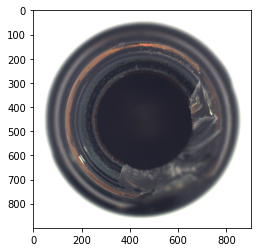

In [25]:

#load a test images
image_path = root_directory / "test_images/000.png"
image = read_image(path=image_path)
plt.imshow(image)
normalization = InputNormalizationMethod(config.dataset.normalization)
transform_config = config.dataset.transform_config.eval if "transform_config" in config.dataset.keys() else None
transform = get_transforms(
        config=transform_config, image_size=tuple(config.dataset.image_size), center_crop=config.dataset.get("center_crop"), normalization=normalization
    )

##apply transformation on the input image
dataset = InferenceDataset(
        image_path, image_size=tuple(config.dataset.image_size), transform=transform  # type: ignore
    )
dataloader = DataLoader(dataset)

In [26]:
output_path = Path(config["project"]["path"])
print(output_path)
pytorch_model_path = output_path / "weights" / "lightning" / "model.ckpt"

/ssd003/projects/aieng/public/anomaly_detection_models/MVtec/draem/mvtec/bottle/run


In [28]:
# generate predictions
predictions = trainer.predict(model=model, dataloaders=[dataloader])[0]

print(predictions.keys())


print(
    f'Image Shape: {predictions["image"].shape},\n'
    'Anomaly Map Shape: {predictions["anomaly_maps"].shape}, \n'
    'Predicted Mask Shape: {predictions["pred_masks"].shape}'
)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  1.65it/s]
dict_keys(['image', 'image_path', 'anomaly_maps', 'pred_scores', 'pred_labels', 'pred_masks', 'pred_boxes', 'box_scores', 'box_labels'])
Image Shape: torch.Size([1, 3, 256, 256]),
Anomaly Map Shape: {predictions["anomaly_maps"].shape}, 
Predicted Mask Shape: {predictions["pred_masks"].shape}


Image Shape: (256, 256, 3)
 Min Pixel: 29 
 Max Pixel: 255


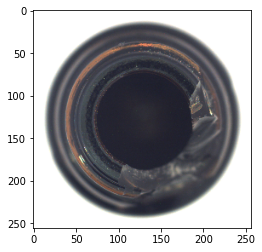

In [29]:
image = predictions["image"][0]
image = Denormalize()(image)
print(f"Image Shape: {image.shape}\n Min Pixel: {image.min()} \n Max Pixel: {image.max()}")

plt.imshow(image)

## Anomaly Map

The second output of the predictions is the anomaly map. As can be seen above, it's also a torch tensor and of size torch.Size([1, 1, 256, 256]). We therefore need to convert it to numpy and squeeze the dimensions to make it 256x256 output to visualize.

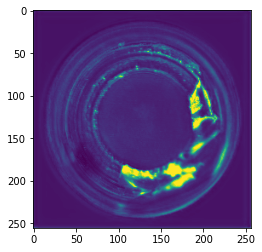

In [30]:
anomaly_map = predictions["anomaly_maps"][0]
anomaly_map = anomaly_map.cpu().numpy().squeeze()
plt.imshow(anomaly_map)

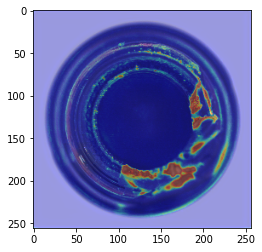

In [31]:
heat_map = superimpose_anomaly_map(anomaly_map=anomaly_map, image=image, normalize=True)
plt.imshow(heat_map)

In [32]:
pred_score = predictions["pred_scores"][0]
pred_labels = predictions["pred_labels"][0]
print(pred_score, pred_labels)

tensor(0.6632) tensor(True)


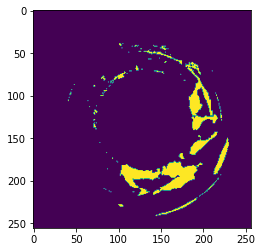

In [33]:
pred_masks = predictions["pred_masks"][0].squeeze().cpu().numpy()
plt.imshow(pred_masks)

## Model - CFA

In this part, we'll be using [CFA: Coupled-Hypersphere-Based Feature Adaptation for Target-Oriented Anomaly Localization](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9839549). Now, let's get their config paths from the respected folders.

## CFA Structure
<center>
<img src="https://drive.google.com/uc?export=view&id=1P5CmWbqx9_Xb9-P-D_38A02L5e0qOKDg" width="100%" style="float:center;">
</center>


## CFA _ Feature Extraction and Training Path

*   Inferring samples of the target dataset based on a pre-trained CNN with a large dataset, that is, a biased CNN. Since the feature maps sampled at each depth of CNN have different spatial resolutions, they are interpolated to have the same resolution and then concatenated.
*   As a result, patch features $\mathcal{F} \in \mathbb{R}^{D \times H \times W}$ are generated. H and W mean the height and width of the largest features map, respectively and D indicates the sum of dimensions of the sampled feature maps.patch feature can be considered as semantic information at the pixel location.
*   Used ResNet18 / Wide ResNet-50 as frozen CNN part.
* Patch Descriptor: An auxiliary network with learnable parameters which converts patch features into target oriented features.
* Memory Bank: Storing memorized features. Understanding normal features.


<center>
<img src="https://drive.google.com/uc?export=view&id=1HTChBa68iWqaNdwnGBmk42DAi5V836Pn" width="600" aligh="center">
</center>

## CFA _ Memory Bank Compression

* Transfer learning through the proposed CFA requires a memory bank for effective adaptation to the target dataset.

* First, an initial memory bank $\mathcal{C}_0$ is constructed by applying $\mathrm{K}$-means clustering to all $\phi_0\left(\mathbf{p}_{t \in\{1, \ldots, T\}}\right)$ obtained from the first normal samples $\mathbf{x}_0$ of the train set $\mathcal{X}$. The process of updating the memory bank after $\mathcal{C}_0$ is as follows:
* Infer the $i$-th normal sample $\mathbf{x}_i$ and search for the set of nearest patch features $\mathcal{C}_i^{N N}$ from the $i$-1th memory bank $\mathcal{C}_{i-1}$.
* Next, the $i$-th memory bank of the next state $\mathcal{C}_i$ is calculated by exponential moving average (EMA) of $\mathcal{C}_i^{N N}$ and $\mathcal{C}_{i-1}$.
* The final memory bank $\mathcal{C}$ is obtained by repeating the above process $|\mathcal{X}|$ times for all normal samples of the train set.



<center>
<img src="https://drive.google.com/uc?export=view&id=1Se3xKggBLJMpWgwIwnJuDSUVh4EyqVta" width="600" aligh="center">
</center>

## CFA _ Attraction Loss Function

$$
\mathcal{L}_{a t t}=\frac{1}{T K} \sum_{t=1}^T \sum_{k=1}^K \max \left\{0, \mathcal{D}\left(\phi\left(\mathbf{p}_t\right), \mathbf{c}_t^k\right)-r^2\right\}
$$

* ${T}:\text{Number of total patch features}$
* ${K}:\text{Number of nearest neighbors}$
* ${D(a,b)}:\text{Euclidean distance between a and b}$
* $\phi\left(\mathbf{p}_t\right): \text{Patch Descriptor}$
* ${c}: \text{Centers}$
* ${r}: \text{Radius}$


<center>
<img src="https://drive.google.com/uc?export=view&id=1-obaxof5sIbeV1k7tV7c86oYRUXEsEg6" width="400" aligh="center">
</center>

## CFA _ Repel Loss Function


$$
\mathcal{L}_{\text {rep }}=\frac{1}{T J} \sum_{t=1}^T \sum_{j=1}^J \max \left\{0, r^2-\mathcal{D}\left(\phi\left(\mathbf{p}_t\right), \mathbf{c}_t^j\right)-\alpha\right\}
$$


* ${T}:\text{Number of total patch features}$
* ${J}:\text{Total numebr of hard negative features}$
* ${D(a,b)}:\text{Euclidean distance between a and b}$
* $\phi\left(\mathbf{p}_t\right): \text{Patch Descriptor}$
* ${c}: \text{Centers}$
* ${r}: \text{Radius}$
* ${\alpha}: \text{is used to control the balance between } \mathcal{L}_{\text {att }} \text{and } \mathcal{L}_{\text {rep }}$

$$
\mathcal{L}_{C F A}=\mathcal{L}_{a t t}+\mathcal{L}_{r e p}
$$

<center>
<img src="https://drive.google.com/uc?export=view&id=1-obaxof5sIbeV1k7tV7c86oYRUXEsEg6" width="400" aligh="center">
</center>

## CFA _ Scoring Function

* means the minimum distance between patch descriptor φ(pt) and the memorized features C.


$$
\mathcal{S}_t=\min _k \mathcal{D}\left(\phi\left(\mathbf{p}_t\right), \mathbf{c}_t^k\right)
$$



<center>
<img src="https://drive.google.com/uc?export=view&id=10GRUtPgnI5m5NlY2TV2D9Qdsubndv9Ap" width="300" aligh="center">
</center>

## CFA _ Time Complexity



<center>
<img src="https://drive.google.com/uc?export=view&id=1pPgZvk2EQ8QDtr8bqGCNC3tmmSfGDPzu" width="500" aligh="center">
</center>

## CFA _ Results
* AUROC : ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1
* I-AUROC: Image level AUROC
* P-AUROC: Pixel Level AUROC
* CFA++: Refers to a case that ensembles the results when using cropped images and using only resized samples.



<center>
<img src="https://drive.google.com/uc?export=view&id=1cnSfMrtU4aEyfRyx6zCOFOXvCKDYDOf7" width="900" aligh="center">
</center>

## Configuration

In this demonstration, we will work with [CFA](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9839549) model. Let's take a quick look at its config file.
We control various parameters in the config file:

**input data path** | **Dataset Category** | **Batch Sizes** | **Input Image size** | **# of Epochs** | **Saving Path**

In [47]:
MODEL = "cfa" # choosing the model 
CONFIG_PATH = root_directory / f"src/anomalib/models/{MODEL}/config.yaml" # detailed configs loaded from this file
print(CONFIG_PATH)

/ssd003/home/mpourreza/Projects/MVTec/anomalib/src/anomalib/models/cfa/config.yaml


We could use [get_configurable_parameter](https://github.com/openvinotoolkit/anomalib/blob/main/anomalib/config/config.py#L114) function to read the configs from the path and return them in a dictionary. We use the default config file that comes with CFA implementation, which uses defined path as the path to the dataset. We need to overwrite this after loading the config.

In [56]:
# pass the config file to model, callbacks and datamodule
config = get_configurable_parameters(config_path=CONFIG_PATH)
print(config.dataset.category)
config.dataset.category = "bottle" # Choosing the classes from MVTec classes

wood


**Download MVTEC Dataset**

The provided source code initializes a data module using a given configuration, prepares the data by downloading the dataset if it's not already present in the specified root directory, and sets up the data module by creating train/validation/test/prediction sets. It then retrieves a batch of data from the validation data loader and prints the keys of the data dictionary to examine the available data fields.

In [8]:
datamodule = get_datamodule(config)
datamodule.prepare_data()  # Downloads the dataset if it's not in the specified `root` directory
datamodule.setup()  # Create train/val/test/prediction sets.

i, data = next(enumerate(datamodule.val_dataloader()))
print(data.keys())

dict_keys(['image_path', 'label', 'image', 'mask_path', 'mask'])


## Mask


In the context of the MVTEC test dataset, the "mask" refers to an additional array or image that accompanies each input image. The purpose of the mask is to provide annotations or labels indicating the regions within the image that contain anomalies or defects. The mask is typically binary, where the anomaly regions are marked as foreground (non-zero values) and the normal regions are marked as background (zero values).

Let's check the shapes of the input images and masks.

In [9]:
print(data["image"].shape, data["mask"].shape)

torch.Size([4, 3, 224, 224]) torch.Size([4, 224, 224])


We could now visualize a normal and abnormal sample from the validation set.

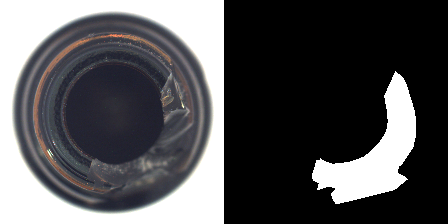

In [10]:
def show_image_and_mask(sample: dict[str, Any], index: int) -> Image:
    """
    Display an image and its corresponding mask side by side.

    Args:
        sample (dict[str, Any]): A dictionary containing the image and mask arrays.
        index (int): The index of the specific image and mask to display.

    Returns:
        Image: The concatenated image and mask as a PIL Image object.
    """
    img = ToPILImage()(Denormalize()(sample["image"][index].clone()))
    msk = ToPILImage()(sample["mask"][index]).convert("RGB")

    return Image.fromarray(np.hstack((np.array(img), np.array(msk))))


# Visualize an image with a mask
show_image_and_mask(data, index=0)

## Train - Prepare Model and Callbacks

Now, the config file is updated as we want. We can now start model training with it. Here we will be using `datamodule`, `model` and `callbacks` to train the model. Callbacks are self-contained objects, which contains non-essential logic. This way we could inject as many callbacks as possible such as ModelLoading, Timer, Metrics, Normalization and Visualization

In addition to the training, we would like to perform inference using PyTorch model. Therefore we will set the export configuration to "torch" so that anomalib would export the trained model to the .cpkt format.

In [11]:
# Set the export-mode to Torch to create the torch model.
config.optimization.export_mode = "torch"

# Get the model and callbacks / Download the wide_resnet50 from pytorh hub
model = get_model(config)
callbacks = get_callbacks(config)

Downloading: "https://download.pytorch.org/models/wide_resnet50_2-95faca4d.pth" to /h/mpourreza/.cache/torch/hub/checkpoints/wide_resnet50_2-95faca4d.pth
100%|██████████| 132M/132M [00:01<00:00, 116MB/s]  


In [12]:
# start training
trainer = Trainer(**config.trainer, callbacks=callbacks)
trainer.fit(model=model, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(limit_train_batches=1.0)` was configured so 100% of the batches per epoch will be used..
`Trainer(limit_val_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_test_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(limit_predict_batches=1.0)` was configured so 100% of the batches will be used..
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                  | Type                     | Params
-------------------------------------------------------------------
0 | image_threshold       | AnomalyScoreThreshold    | 0     
1 | pixel_threshold       | AnomalyScoreThreshold    | 0     
2 | model                 | CfaModel                 | 31.3 M
3 | loss             

Training: 0it [00:00, ?it/s]


100%|██████████| 53/53 [00:14<00:00,  3.77it/s]

Epoch 0:   0%|          | 0/74 [00:00<?, ?it/s] 

Epoch 0:  72%|███████▏  | 53/74 [00:11<00:04,  4.53it/s, loss=627, v_num=6]     
Validation: 0it [00:00, ?it/s]
Epoch 1:  72%|███████▏  | 53/74 [00:11<00:04,  4.80it/s, loss=386, v_num=6, pixel_AUROC=0.989]
Validation: 0it [00:00, ?it/s]
Epoch 2:  72%|███████▏  | 53/74 [00:11<00:04,  4.62it/s, loss=337, v_num=6, pixel_AUROC=0.989]
Validation: 0it [00:00, ?it/s]
Epoch 3:  72%|███████▏  | 53/74 [00:11<00:04,  4.77it/s, loss=305, v_num=6, pixel_AUROC=0.989]
Validation: 0it [00:00, ?it/s]
Epoch 4:  72%|███████▏  | 53/74 [00:11<00:04,  4.59it/s, loss=281, v_num=6, pixel_AUROC=0.989]
Validation: 0it [00:00, ?it/s]
Epoch 5:  72%|███████▏  | 53/74 [00:11<00:04,  4.56it/s, loss=261, v_num=6, pixel_AUROC=0.989]
Validation: 0it [00:00, ?it/s]
Epoch 6:  72%|███████▏  | 53/74 [00:11<00:04,  4.44it/s, loss=242, v_num=6, pixel_AUROC=0.989]
Validation: 0it [00:00, ?it/s]
Epoch 7:  72%|███████▏  | 53/74 [00:11<00:04,  4.43it/s, loss=228, v_num=6, pixel_AUROC=0.989]
Validation: 0it [00:00, ?it/s]
Epoch 

Epoch 8:  72%|███████▏  | 53/74 [00:11<00:04,  4.42it/s, loss=215, v_num=6, pixel_AUROC=0.989]
Validation: 0it [00:00, ?it/s]
Epoch 9:  72%|███████▏  | 53/74 [00:12<00:04,  4.40it/s, loss=207, v_num=6, pixel_AUROC=0.989]
Validation: 0it [00:00, ?it/s]
Epoch 9: 100%|██████████| 74/74 [00:20<00:00,  3.69it/s, loss=207, v_num=6, pixel_AUROC=0.989]


## Validation

In [18]:
# load best model from checkpoint before evaluating
load_model_callback = LoadModelCallback(weights_path=trainer.checkpoint_callback.best_model_path)
trainer.callbacks.insert(0, load_model_callback)
test_results = trainer.test(model=model, datamodule=datamodule)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping


/ssd003/projects/aieng/public/anomaly_detection_models/MVtec/cfa/mvtec/bottle/run/weights/lightning/model.ckpt


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 21/21 [00:31<00:00,  1.51s/it]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       image_AUROC          0.9976190328598022
       pixel_AUROC          0.9892481565475464
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


### Inference
Since we have a trained model, we could infer the model on an individual image or folder of images. Anomalib has an InferenceDataset to let you create an inference dataset. So let's try it.

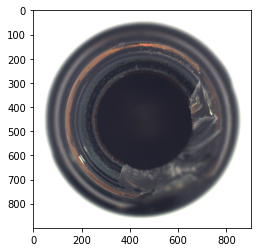

In [19]:
# Load a Test Image
image_path = root_directory / "test_images/000.png"
image = read_image(path=image_path)
plt.imshow(image)

# Define normalization and transformation
normalization = InputNormalizationMethod(config.dataset.normalization)
transform_config = config.dataset.transform_config.eval if "transform_config" in config.dataset.keys() else None
transform = get_transforms(
        config=transform_config, image_size=tuple(config.dataset.image_size), center_crop=config.dataset.get("center_crop"), normalization=normalization
    )

# Apply transformation on the input image
dataset = InferenceDataset(
        image_path, image_size=tuple(config.dataset.image_size), transform=transform  # type: ignore
    )
dataloader = DataLoader(dataset)


### Load the Pytorch Model

By default, the output files are saved into predefined path in config file. Let's check where the pytorch model is stored.

In [20]:
output_path = Path(config["project"]["path"])
print(output_path)

/ssd003/projects/aieng/public/anomaly_detection_models/MVtec/cfa/mvtec/bottle/run


In [21]:
pytorch_model_path = output_path / "weights" / "lightning" / "model.ckpt"


predictions contain image, anomaly maps, predicted scores, labels and masks. These are all stored in a dictionary. 
We could check this by printing the prediction keys.

In [22]:
# generate predictions
predictions = trainer.predict(model=model, dataloaders=[dataloader])[0]

print(predictions.keys())


print(
    f'Image Shape: {predictions["image"].shape},\n'
    'Anomaly Map Shape: {predictions["anomaly_maps"].shape}, \n'
    'Predicted Mask Shape: {predictions["pred_masks"].shape}'
)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]
dict_keys(['image', 'image_path', 'anomaly_maps', 'pred_scores', 'pred_labels', 'pred_masks', 'pred_boxes', 'box_scores', 'box_labels'])
Image Shape: torch.Size([1, 3, 224, 224]),
Anomaly Map Shape: {predictions["anomaly_maps"].shape}, 
Predicted Mask Shape: {predictions["pred_masks"].shape}


### Visualization
To properly visualize the predictions, we will need to perform some post-processing operations.

Let's post-process each output one by one. We could start with the image. Each image is a tensor and within (0, 1) range. To visualize it, we need to denormalize it to (0, 255) scale. Anomalib already has a class for this. Let's use it.

Image Shape: (224, 224, 3)
 Min Pixel: 27 
 Max Pixel: 255


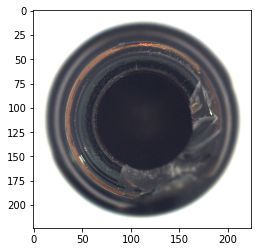

In [18]:
image = predictions["image"][0]
image = Denormalize()(image)
print(f"Image Shape: {image.shape}\n Min Pixel: {image.min()} \n Max Pixel: {image.max()}")

# Display the image
plt.imshow(image)

## Anomaly Map

The second output of the predictions is the anomaly map. As can be seen above, it's also a torch tensor and of size torch.Size([1, 1, 256, 256]). We therefore need to convert it to numpy and squeeze the dimensions to make it 256x256 output to visualize.

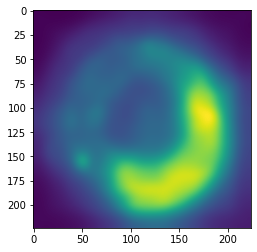

In [19]:
anomaly_map = predictions["anomaly_maps"][0]
anomaly_map = anomaly_map.cpu().numpy().squeeze()
plt.imshow(anomaly_map)

We could superimpose (overlay) the anomaly map on top of the original image to get a heat map. Anomalib has a built-in function to achieve this. Let's try it.

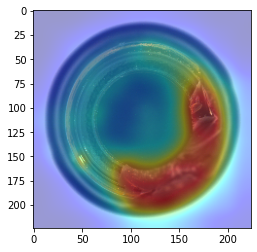

In [20]:
heat_map = superimpose_anomaly_map(anomaly_map=anomaly_map, image=image, normalize=True)
plt.imshow(heat_map) #plot heatmap

predictions also contains prediction scores and labels.

In [21]:
pred_score = predictions["pred_scores"][0]
pred_labels = predictions["pred_labels"][0]
print(pred_score, pred_labels)

tensor(0.7623) tensor(True)


The last part of the predictions is the mask that is predicted by the model. This is a boolean mask containing True/False for the abnormal/normal pixels, respectively.

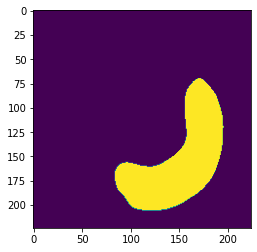

In [22]:
pred_masks = predictions["pred_masks"][0].squeeze().cpu().numpy()
plt.imshow(pred_masks)

## Further Reading

* [Towards Total Recall in Industrial Anomaly Detection](https://openaccess.thecvf.com/content/CVPR2022/html/Roth_Towards_Total_Recall_in_Industrial_Anomaly_Detection_CVPR_2022_paper.html)

* [PaDiM: a Patch Distribution Modeling Framework for Anomaly Detection and Localization
](https://arxiv.org/abs/2011.08785)

* [SimpleNet: A Simple Network for Image Anomaly Detection and Localization](https://openaccess.thecvf.com/content/CVPR2023/html/Liu_SimpleNet_A_Simple_Network_for_Image_Anomaly_Detection_and_Localization_CVPR_2023_paper.html)

## Gradio and Hugging Face

We have created an anomaly detection model based on the CFA architecture trained on the MVTEC Test dataset. The CFA model is a deep learning-based approach that can identify anomalies or defects in various object and texture categories commonly encountered in industrial inspection tasks.

Features:
- Pretrained CFA model for anomaly detection
- Interactive web-based demo using Gradio
- Easy-to-use interface for uploading test images and obtaining anomaly predictions
- Efficient inference with GPU support
- Seamless integration with Hugging Face Spaces for model sharing and deployment
  
Access the project's Hugging Face Spaces page at https://huggingface.co/spaces/masoudpz/cfa_mvtec_test.



<center>
<img src="https://drive.google.com/uc?export=view&id=1mRLfZnf8xSR34Ee6Wq8XiZB1pyVvv5Xl
" width="700" aligh="center">
</center>


## Gradio Key Features

* [Adding example inputs](https://gradio.app/key-features/#example-inputs)
* [Passing custom error messages](https://gradio.app/key-features/#errors)
* [Adding descriptive content](https://gradio.app/key-features/#descriptive-content)
* [Setting up flagging](https://gradio.app/key-features/#flagging)
* [Preprocessing and postprocessing](https://gradio.app/key-features/#preprocessing-and-postprocessing)
* [Styling demos](https://gradio.app/key-features/#styling)
* [Queuing users](https://gradio.app/key-features/#queuing)
* [Iterative outputs](https://gradio.app/key-features/#iterative-outputs)
* [Progress bars](https://gradio.app/key-features/#progress-bars)
* [Batch functions](https://gradio.app/key-features/#batch-functions)
* [Running on collaborative notebooks](https://gradio.app/key-features/#colab-notebooks)
* [Caching Data and states](https://gradio.app/more-on-examples/#caching-examples)




## References

1. [CFA: Coupled-Hypersphere-Based Feature
Adaptation for Target-Oriented
Anomaly Localization](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9839549)

2. [DRÆM–Adiscriminativelytrainedreconstructionembeddingforsurface anomalydetection](https://openaccess.thecvf.com/content/ICCV2021/papers/Zavrtanik_DRAEM_-_A_Discriminatively_Trained_Reconstruction_Embedding_for_Surface_Anomaly_ICCV_2021_paper.pdf)
3. [PyOD Package](https://github.com/yzhao062/pyod)
4.[Anomlaib Package](https://github.com/openvinotoolkit/anomalib) 